# Model Evaluation & Optimization 

A real world Titanic dataset has been used to train data. The training set should be used to build machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. The models will be based on “features” like passengers’ gender and class. We may also use feature engineering to create new features. The model predicts whether or not the passengers survived the sinking of the Titanic.

### Data Dictionary

| Variable | Definition | Key |
| ----------- | ----------- | ----------- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Gender | Male, Female |
| Age |	Age in years|  |	
| sibsp	| # of siblings / spouses aboard the Titanic |  |	
| parch |	# of parents / children aboard the Titanic|  |	
| ticket |	Ticket number	|  |
| fare |	Passenger fare |  |	
| cabin |	Cabin number |  |
| embarked |	Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations as follows,
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations as follows,
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

The objective of this work is to,

1. Build and evaluate 9 classifers including decision tree, Random Forest, AdaBoost, Gradient Boosting, Logistic regression, support vector machines, k-nearest neighbors, naïve Bayes and artificial neural network with two hidden layers to predict whether the passengers survived the sinking of the Titanic. 
2.	Compare the performance of all the nine classifiers using ROC-AUC as well as confusion-matrix based performance evaluation measures. Select the “best performer” on the hold-out testset.
3.	Perform hyper-parameters tuning to optimize the “best performer” from the previous step using Randomized-search.

In [1]:
# importing packages
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv('titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Comment:

From the above table, we can observe that the features **Age, Cabin, and Embarked** have missing data. 
- **Cabin:** This feature has more than 50% of the data missing. Hence it is ideal to drop this column
- **Embarked:** This feature has 2 missing values which can be neglected.
- **Age:** This feature has approxiamately 20% missing values which needs to be handled.

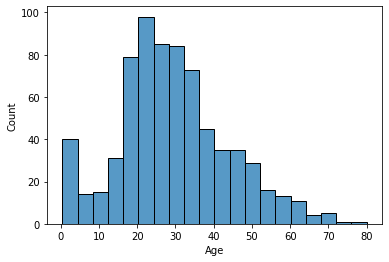

In [4]:
sns.histplot(x='Age', data=df, bins=20);

### Comment: 
We observe that the feature age is slightly right skewed and some outliers. Hence it is optimal to use backfill, forward fill or median to replace the missing values. For this lab, we would use median to replace the missing values.

Reference: https://medium.com/analytics-vidhya/appropriate-ways-to-treat-missing-values-f82f00edd9be

We can also drop columns **Name** and **Ticket** as they provide no information for analysis.

In [5]:
df = df.drop(['Cabin','Name','Ticket'], axis =1)
df['Age']=df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
df = pd.get_dummies(df)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [6]:
df = df.drop(['PassengerId','Sex_female'],axis=1)
df.rename(columns = {'Sex_male':'Sex'},inplace = True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1


In [7]:
cols = ['Pclass','Sex', 'Age','SibSp','Parch', 'Fare','Embarked_C','Embarked_Q','Embarked_S']
X = df[cols]
y= df['Survived']
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [8]:
y_test.value_counts()

0    110
1     69
Name: Survived, dtype: int64

## Decision Tree

/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


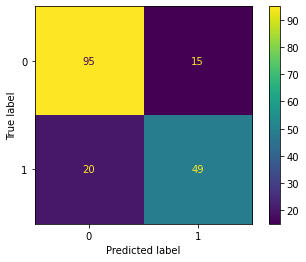

In [9]:
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       110
           1       0.77      0.71      0.74        69

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


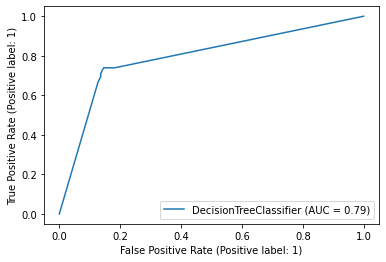

In [11]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Random Forest

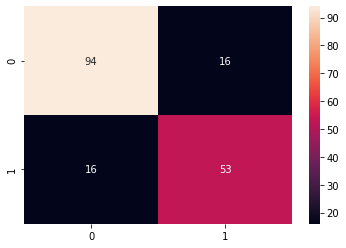

In [12]:
#define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [13]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.77      0.77      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


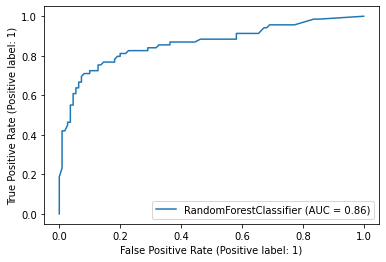

In [14]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## 3. AdaBoost 

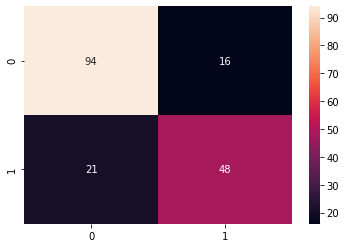

In [15]:
# cols = ['Pclass','Sex', 'Age','SibSp','Parch', 'Fare','Embarked_C','Embarked_Q','Embarked_S']
# X = df[cols]
# y= df['Survived']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# define the model
model = AdaBoostClassifier()
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [16]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


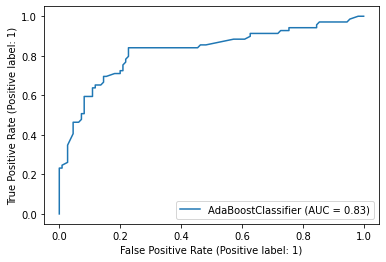

In [17]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## 4. Gradient Boosting Classifier

/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


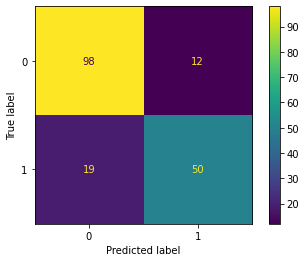

In [18]:
# cols = ['Pclass','Sex', 'Age','SibSp','Parch', 'Fare','Embarked_C','Embarked_Q','Embarked_S']
# X = df[cols]
# y= df['Survived']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# define the model
model = GradientBoostingClassifier()
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [19]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


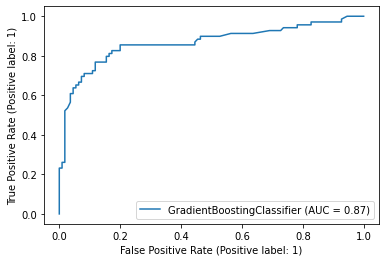

In [20]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Logistic Regression

/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


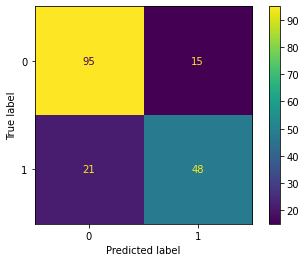

In [21]:
# define the model
model = LogisticRegression()

# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [22]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


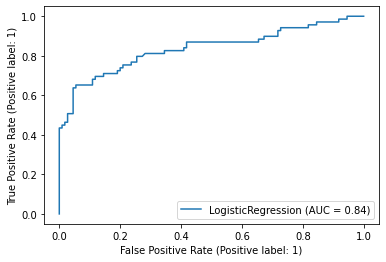

In [23]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Support vector machines

/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


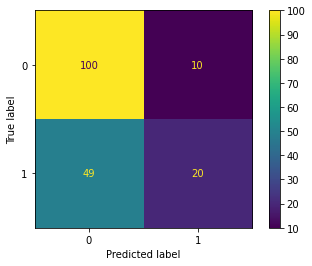

In [24]:
# cols = ['Pclass','Sex', 'Age','SibSp','Parch', 'Fare','Embarked_C','Embarked_Q','Embarked_S']
# X = df[cols]
# y= df['Survived']
# # define the model
model = svm.SVC()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# # fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [25]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       110
           1       0.67      0.29      0.40        69

    accuracy                           0.67       179
   macro avg       0.67      0.60      0.59       179
weighted avg       0.67      0.67      0.63       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


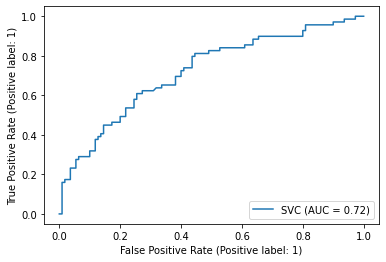

In [26]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## K-Nearest Neighbour

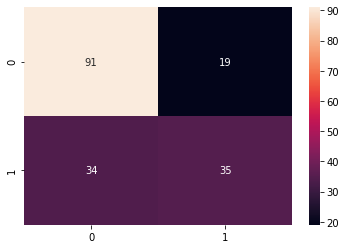

In [27]:
# cols = ['Pclass','Sex', 'Age','SibSp','Parch', 'Fare','Embarked_C','Embarked_Q','Embarked_S']
# X = df[cols]
# y= df['Survived']
# # define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [28]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.73      0.83      0.77       110
           1       0.65      0.51      0.57        69

    accuracy                           0.70       179
   macro avg       0.69      0.67      0.67       179
weighted avg       0.70      0.70      0.70       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


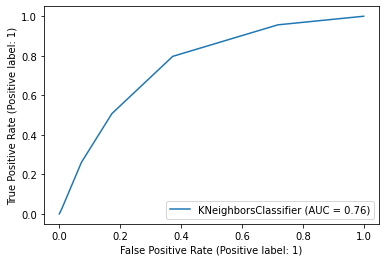

In [29]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Naives Bayes

/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


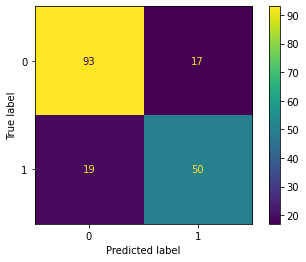

In [30]:
# cols = ['Pclass','Sex', 'Age','SibSp','Parch', 'Fare','Embarked_C','Embarked_Q','Embarked_S']
# X = df[cols]
# y= df['Survived']
# # define the model
model = GaussianNB()
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [31]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.75      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


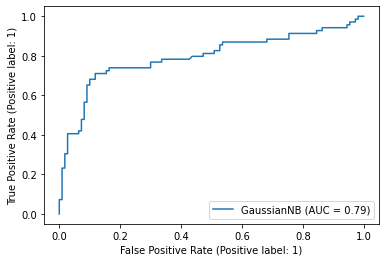

In [32]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Artificial Neural Network

/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


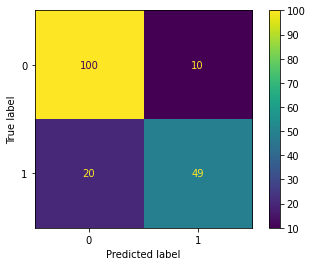

In [33]:
# cols = ['Pclass','Sex', 'Age','SibSp','Parch', 'Fare','Embarked_C','Embarked_Q','Embarked_S']
# X = df[cols]
# y= df['Survived']
# define the model
model = MLPClassifier(hidden_layer_sizes=(100,100))
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [34]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.71      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



/Users/prernamehta/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


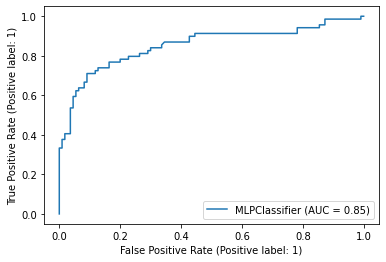

In [35]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Comments:

### Classification Report and AUC score

We look into the Classification Reports and AUC score of all the models and is given as following,

| Model | Accuracy | F1 score | Precision | Recall | AUC-score
|----------|----------|----------|----------|----------|----------|
|Decision Tree| 0.82 | 0.81 | 0.81 | 0.81 | 0.81 |
|Random Forest| 0.83 | 0.81 | 0.82 | 0.91 | 0.86 |
|AdaBoost| 0.79 | 0.78 | 0.78 | 0.77 | 0.83 |
|Gradient Boosting| 0.83 | 0.81 | 0.82 | 0.80 | 0.87 |
|Logistic Regression| 0.80 | 0.78 | 0.79 | 0.78 | 0.84 |
|Support vector Machine | 0.67 | 0.58 | 0.67 | 0.60 | 0.72 |
|KNN| 0.70 | 0.67 | 0.69 | 0.67 | 0.76 |
|Naive Bayes| 0.80 | 0.79 | 0.79 | 0.78 | 0.79 |
|ANN| 0.79 | 0.76 | 0.82 | 0.74 | 0.85 |

Based on the classification report and AUC score, we can says that ***Random Forest*** and ***Gradient Boosting*** performs well, however, the number of FP instances for random forest is less than that of Gradient Boosting, hence we can say that random forest is the best performer for the given dataset.
 
## Optimisation of Hyperparameters

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestClassifier()

""" Random search of parameters, using 3 fold cross validation, search across 100 different combinations, 
    and use all available cores"""
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, 
                                  verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
model_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 218, 236, 254,
                                                         272, 290, 309, 327,
                                                         345, 363, 381, 400,
                                                         418, 436, 454, 472,
                                                         490, 509, 527, 545,
                                                         563, 581, 600, 618,
                                                         636, 654, 672, 690,
                                                         709, 727, ...]},
                   random_state=42, verbose=2)

In [37]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
predictions = base_model.predict(X_test)
predictions=predictions.reshape(179,1)
from sklearn.metrics import accuracy_score
base_accuracy=accuracy_score(y_test, predictions)

In [38]:
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
model_random.fit(X_train, y_train)
best_random = model_random.best_estimator_
best_random.fit(X_train, y_train)
predictions = best_random.predict(X_test)
predictions=predictions.reshape(179,1)
random_accuracy=accuracy_score(y_test, predictions)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [39]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 2.74%.


### Comments:

We used Randomized Search to optimise the hyperparameters and observed 2.74% improvement in terms of accuracy.